## K-Means Clustering using PySpark Python

In this tutorial series, we are going to cover K-Means Clustering using Pyspark. K-means is a clustering algorithm that groups data points into K distinct clusters based on their similarity. It is an unsupervised learning technique that is widely used in data mining, machine learning, and pattern recognition. The algorithm works by iteratively assigning data points to a cluster based on their distance from the cluster's centroid and then recomputing the centroid of each cluster. The process continues until the clusters' centroids converge or a maximum number of iterations is reached. K-means is simple, efficient, and effective in finding the optimal clusters for a given dataset, making it a popular choice for various applications.

So, a typical clustering problem looks like this:

- Cluster Similar Documents
- Cluster Customers based on Features
- Identify similar physical groups
- Market Segmentation
  
We'll be working with a real data set about seeds, from the UCI repository: https://archive.ics.uci.edu/dataset/236/seeds

**Task: We have seven geometrical parameters of wheat kernels and we have to group them into three different varieties of wheat: Kama, Rosa, and Canadian.**

### Step 1: Starting the PySpark server 

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('cluster').getOrCreate()
print('Spark Version: {}'.format(spark.version))

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/31 17:14:58 WARN Utils: Your hostname, GERARD, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/10/31 17:14:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/31 17:15:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 4.0.1


### Step 2: Load the dataset

#### Download the data

In [2]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt


--2025-10-31 17:15:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘seeds_dataset.txt.1’

seeds_dataset.txt.1     [ <=>                ]   9.08K  --.-KB/s    in 0.001s  

2025-10-31 17:15:04 (7.89 MB/s) - ‘seeds_dataset.txt.1’ saved [9300]



#### Converting the txt file into csv one using pandas

In [3]:
import pandas as pd

df = pd.read_csv(
    "seeds_dataset.txt",
    delim_whitespace=True,
    header=None,
    names=[
        "area", "perimeter", "compactness", "length_kernel",
        "width_kernel", "asymmetry", "length_groove", "class"
    ]
)

df.to_csv("seeds_dataset.csv", index=False)
print("✅ Saved seeds_dataset.csv")


✅ Saved seeds_dataset.csv


/tmp/ipykernel_14374/1102510321.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


#### Loading the data with sparkContext

In [4]:
#Loading the data
df = spark.read.csv('seeds_dataset.csv', inferSchema = True, header = True)

# Show dataset
df.show(5)
print(df.count()) # N° of lines

+-----+---------+-----------+-------------+------------+---------+-------------+-----+
| area|perimeter|compactness|length_kernel|width_kernel|asymmetry|length_groove|class|
+-----+---------+-----------+-------------+------------+---------+-------------+-----+
|15.26|    14.84|      0.871|        5.763|       3.312|    2.221|         5.22|    1|
|14.88|    14.57|     0.8811|        5.554|       3.333|    1.018|        4.956|    1|
|14.29|    14.09|      0.905|        5.291|       3.337|    2.699|        4.825|    1|
|13.84|    13.94|     0.8955|        5.324|       3.379|    2.259|        4.805|    1|
|16.14|    14.99|     0.9034|        5.658|       3.562|    1.355|        5.175|    1|
+-----+---------+-----------+-------------+------------+---------+-------------+-----+
only showing top 5 rows
210


#### Print schema

In [5]:
df.printSchema()

root
 |-- area: double (nullable = true)
 |-- perimeter: double (nullable = true)
 |-- compactness: double (nullable = true)
 |-- length_kernel: double (nullable = true)
 |-- width_kernel: double (nullable = true)
 |-- asymmetry: double (nullable = true)
 |-- length_groove: double (nullable = true)
 |-- class: integer (nullable = true)



### Step 3:  Format the data using Vector Assembler into vectors which will be used as "features"

In [6]:
from pyspark.ml.feature import VectorAssembler

vec_assembler = VectorAssembler(inputCols = df.columns,
                                outputCol='features')

final_data = vec_assembler.transform(df)
final_data.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[15.26,14.84,0.87...|
|[14.88,14.57,0.88...|
|[14.29,14.09,0.90...|
|[13.84,13.94,0.89...|
|[16.14,14.99,0.90...|
+--------------------+
only showing top 5 rows


### Step 4: Scaling the data
It is a good idea to scale our data to deal with the curse of dimensionality.

In [7]:
from pyspark.sql import functions as F

df.groupBy('class') \
  .agg(F.count('*').alias('count')) \
  .withColumn('percentage', F.round(F.col('count') / df.count() * 100, 2)) \
  .show()


+-----+-----+----------+
|class|count|percentage|
+-----+-----+----------+
|    1|   70|     33.33|
|    3|   70|     33.33|
|    2|   70|     33.33|
+-----+-----+----------+



In [8]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", 
                        outputCol="scaledFeatures", 
                        withStd=True, 
                        withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(final_data)

# Normalize each feature to have unit standard deviation.
final_data = scalerModel.transform(final_data)

final_data.select('scaledFeatures').show(5)

+--------------------+
|      scaledFeatures|
+--------------------+
|[5.24452795332028...|
|[5.11393027165175...|
|[4.91116018695588...|
|[4.75650503761158...|
|[5.54696468981581...|
+--------------------+
only showing top 5 rows


### Step 5: Find the number of clusters using Silhouette Score

In [9]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    model=kmeans.fit(final_data)
    predictions=model.transform(final_data)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.5976847000603706
Silhouette Score for k = 3 is 0.6915197728249729
Silhouette Score for k = 4 is 0.5614950927076041
Silhouette Score for k = 5 is 0.46821284806318975
Silhouette Score for k = 6 is 0.4053269548488724
Silhouette Score for k = 7 is 0.38697658955416253
Silhouette Score for k = 8 is 0.3636037319815801
Silhouette Score for k = 9 is 0.3955291060342412


#### Plot the Silhouette Score graph

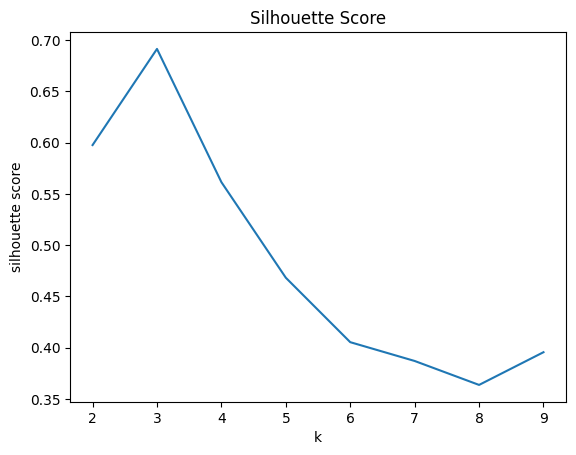

In [10]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt

plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

**Note**: Since there is no definitive answer as to what value of K is an acceptable value. I want to move forward with k = 3 Where a local maximum of Silhouette Score is detected.

### Step 6: Train the Model

In [11]:
# Trains a k-means model.
kmeans = KMeans(featuresCol='scaledFeatures',k=3)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

#### Print cluster centers

In [12]:
# Printing cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 4.08078478 10.1441622  35.94708183 11.80308138  7.55536747  3.18471437
 10.41017906  3.665476  ]
[ 6.31258132 12.36956615 37.37677676 13.90987399  9.73978409  2.40568558
 12.27254041  2.40874137]
[ 4.91494065 10.93132337 37.25846176 12.39806224  8.58634283  1.792494
 10.32818191  1.25673463]


#### Showing the result of groupings:

In [13]:
predictions.select('prediction').show(5)

+----------+
|prediction|
+----------+
|         2|
|         2|
|         2|
|         2|
|         2|
+----------+
only showing top 5 rows


### Step 7: Plot the results

In [14]:
pdf = predictions.select("area", "perimeter", "compactness", "length_kernel",
                         "width_kernel", "asymmetry", "length_groove", "class", "prediction").toPandas()


#### Aply PCA

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pdf[["area", "perimeter", "compactness", "length_kernel",
                                   "width_kernel", "asymmetry", "length_groove"]])
pdf["pca1"] = pca_result[:, 0]
pdf["pca2"] = pca_result[:, 1]


#### Plot the predicted results

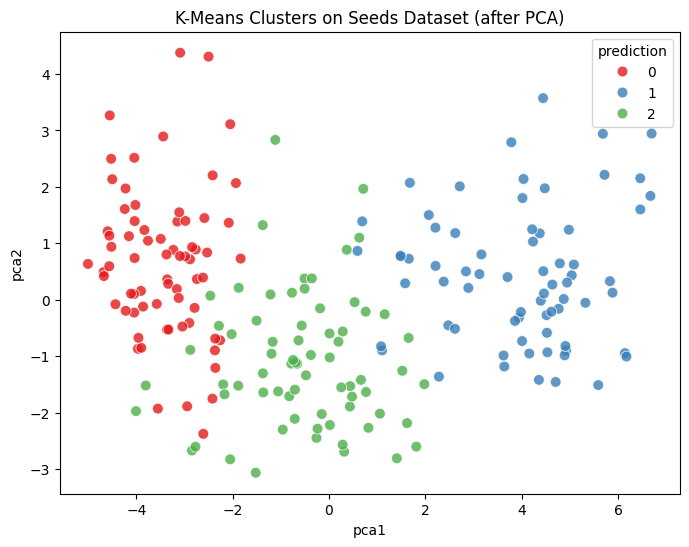

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pdf,
    x="pca1", y="pca2",
    hue="prediction",
    palette="Set1",
    s=60,
    alpha=0.8
)
plt.title("K-Means Clusters on Seeds Dataset (after PCA)")
plt.show()


In [23]:
spark.stop()